In [55]:
import re
import requests
import bs4
import pandas as pd
from spacy import displacy
import spacy
from tqdm import tqdm
import networkx as nx
from spacy.tokens import Span 
from spacy.matcher import Matcher 
import matplotlib.pyplot as plt

nlp = spacy.load('en_core_web_sm')
pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [56]:
f = open("PTCL.txt", "r", encoding = "utf-8")
d = f.read()
d = d.split("\n")

In [57]:
def get_entities(sent):
  entity1 = ""
  entity2 = ""

  previous_tok_dep = ""    # dependency tag of previous token in the sentence
  previous_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""
  
  modular = ""
  ent = ""

  for tok in (nlp(sent)):
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        modular += "m"
        # if the previous word was also a 'compound' then add the current word to it
        if previous_tok_dep == "compound":
          prefix = previous_tok_text + " "+ tok.text
          ent += "0"
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if previous_tok_dep == "compound":
          modifier = previous_tok_text + " "+ tok.text
          modular += "{}".format(len(ent))
      
      if tok.dep_.find("subj") == True:
        entity1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        previous_tok_dep = ""
        previous_tok_text = ""
        ent = ""      

      if tok.dep_.find("obj") == True:
        entity2 = modifier +" "+ prefix +" "+ tok.text
        ent += "2"
        
      # update variables
      previous_tok_dep = tok.dep_
      previous_tok_text = tok.text

  return [entity1.strip(), entity2.strip()]

In [58]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'POS':'ADJ','OP':"?"}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'ROOT'},
            {'DEP':'agent','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [59]:
entity_pairs2 = []

for i in tqdm(d):
  entity_pairs2.append(get_entities(i))

100%|██████████| 90/90 [00:00<00:00, 142.96it/s]


In [60]:
for i in entity_pairs2:
  print(i)

['PTCL', '']
['PTCL', '']
['PTCL', '']
['PTCL', 'customers']
['you', '']
['Mb', 'bits']
['Mb', '1  bits']
['internet', 'customers']
['internet', 'people']
['ISP', '']
['high speed internet', 'fast  internet']
['50  Mb', '50  bits']
['telephone', 'calls']
['MB', 'mega  byte']
['1  MB', '1 mega byte']
['50  MB', '50 mega bytes']
['1  byte', '8  bits']
['8  bits', '1  byte']
['duplicate means', '']
['computer', '']
['you', 'computer']
['high  speed', '']
['soon ISP you', 'computer']
['multiple', 'many']
['', 'same  time']
['desktop', '']
['desktops', '']
['laptop', '']
['psp', 'station pocketsize']
['Wi Fi service', 'free home environment']
['PTCL', 'mail accounts']
['PTCL', 'personalized mail accounts']
['50 Mb Mail', 'exclusive Internet customers']
['application form', 'PTCL website']
['Islamabad', '']
['Pakistan', '']
['Islamabad', 'Pakistan']
['Rawalpindi', 'Pakistan']
['Lahore', 'Pakistan']
['Karachi', 'Pakistan']
['Peshawar', 'Pakistan']
['Hyderabad', 'Pakistan']
['Quetta', 'Pakista

In [61]:
relations2 = [get_relation(i) for i in d]

In [62]:
pd.Series(relations2).value_counts()[:]

is             28
means          13
offers          4
inclusive       4
are             3
informed        2
call            2
request         2
connects        2
has             2
results         2
charged         2
order           2
found           1
using           1
use             1
be              1
change          1
visit           1
provided by     1
accounts        1
check           1
make            1
have            1
providing       1
provided        1
avail           1
remain          1
enables         1
PTCL            1
helpline        1
copy            1
Yes             1
appear          1
used            1
dtype: int64

In [63]:
# extract subject
source = [i[0] for i in entity_pairs2]

# extract object
target = [i[1] for i in entity_pairs2]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations2})

In [64]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

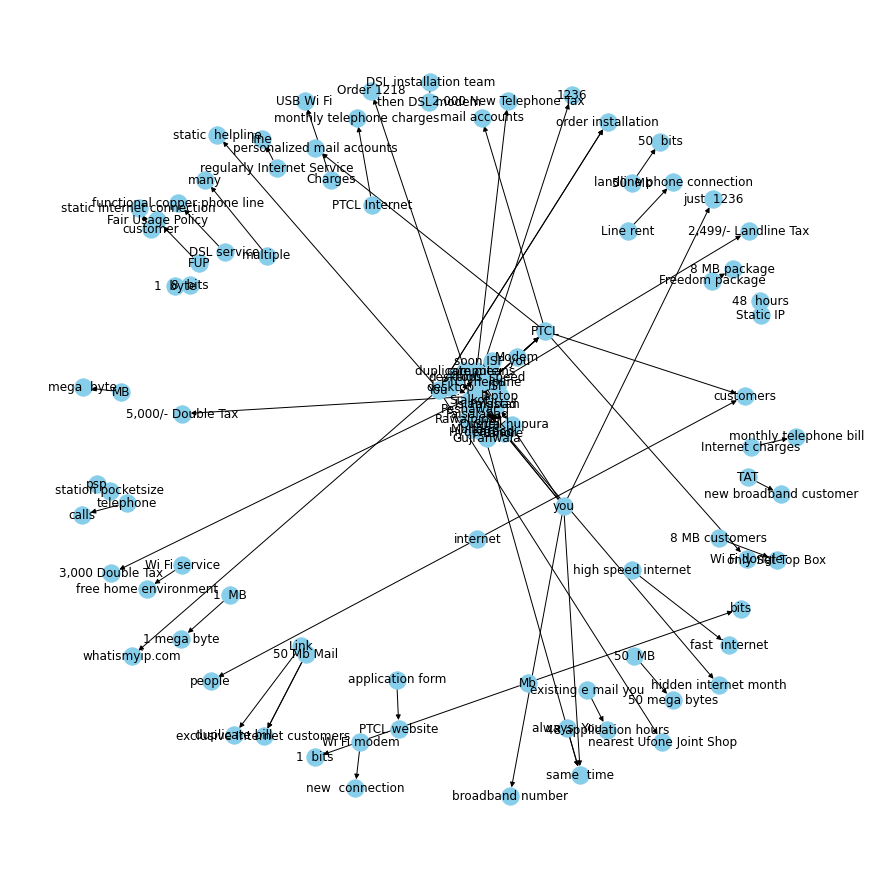

In [65]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

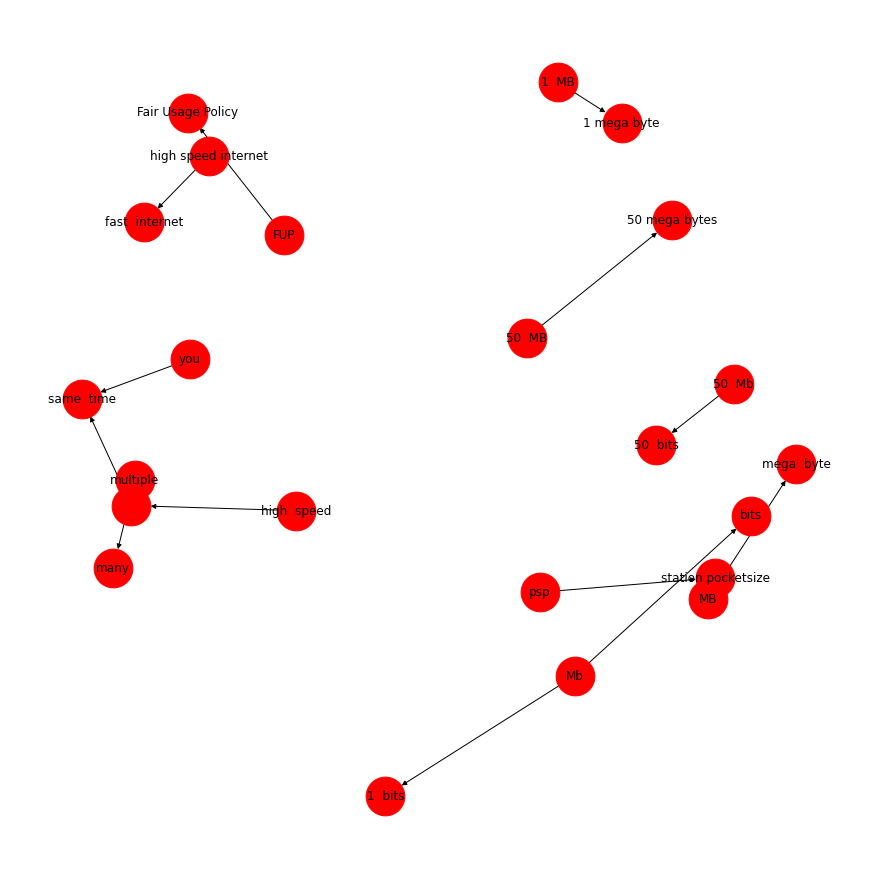

In [66]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="means"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()